## Predictiong Bank Loan Defaults

A data science approach to predict and understand the applicant’s profile to minimize the risk of future loan defaults.


The dataset contains information about credit applicants. Banks, globally, use this kind of dataset and type of informative data to create models to help in deciding on who to accept/refuse for a loan. After all the exploratory data analysis, cleansing and dealing with all the anomalies we might (will) find along the way, the patterns of a good/bad applicant will be exposed to be learned by machine learning models.


Machine Learning issue and objectives We’re dealing with a supervised binary classification problem. The goal is to train the best machine learning model to maximize the predictive capability of deeply understanding the past customer’s profile minimizing the risk of future loan defaults.


Performance Metric - The metric used for the models’ evaluation is the ROC AUC given that we’re dealing with a highly unbalanced data.

Project structure The project divides into three categories:

1. EDA: Exploratory Data Analysis

2. Data Wrangling: Cleansing and Feature Selection

3. Machine Learning: Predictive Modelling

In [7]:
# Importing the Necessary packages

import warnings
warnings.filterwarnings("ignore")
import os
import pickle

import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100)
from scipy import stats

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import mlflow
import mlflow.sklearn

In [8]:
# Defining a function to Get the deatils regarding Missing feature columns.

def missing_details(df):
    missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    dummy = pd.DataFrame(columns = ["name", "missing_count", "missing(%)", "data_type", "no.of_unique", "first_value", "last_value"])
    for col in missing_cols:
        dummy = pd.concat([dummy, pd.DataFrame({"name":df[col].name, "missing_count":df[col].isnull().sum(), "missing(%)":df[col].isnull().sum()/df.shape[0] * 100, "data_type":df[col].dtype, "no.of_unique":df[col].nunique(), "first_value":df[col].iloc[0], "last_value":df[col].iloc[-1]}, index = [0])])
    return dummy

In [9]:
# Loading the data.

data = pd.read_csv(r'C:\Users\lenovo\Desktop\Disha Github\projects\notebook\data\Loan_Default.csv',delimiter=',')

### Exploratory Data Analysis

In [10]:
# Looking at the Data.

data.head()

,id,event_timestamp,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,2016-02-08 00:37:08+00:00,A,100000,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,2016-02-08 05:56:20+00:00,A,83000,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,2016-02-08 06:15:39+00:00,D,78000,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,2016-02-08 06:15:39+00:00,D,37536,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,2016-02-08 06:51:45+00:00,D,65000,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [11]:
# checking the data dimensions.

data.shape

(20000, 16)

Data Checks to perform

- Check Missing values.
- Check Duplicates.
- Check data type.
- Check the number of unique values of each column.
- Check statistics of data set.
- Check various categories present in the different categorical column.

### Check Missing values

In [12]:
# Verifying for the NULL values.

data.isnull().sum()

id                           0
event_timestamp              0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64

- As we can see that several columns contain missing values in the data.

### Check Duplicates

In [13]:
data.duplicated().sum()

0

There are no duplicates values in the data set.

### Check data types

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   event_timestamp        20000 non-null  object 
 2   grade                  20000 non-null  object 
 3   annual_inc             20000 non-null  int64  
 4   short_emp              20000 non-null  int64  
 5   emp_length_num         20000 non-null  int64  
 6   home_ownership         18509 non-null  object 
 7   dti                    19846 non-null  float64
 8   purpose                20000 non-null  object 
 9   term                   20000 non-null  object 
 10  last_delinq_none       20000 non-null  int64  
 11  last_major_derog_none  574 non-null    float64
 12  revol_util             20000 non-null  float64
 13  total_rec_late_fee     20000 non-null  float64
 14  od_ratio               20000 non-null  float64
 15  ba

### Checking the number of unique values of each column

In [15]:
data.nunique()

id                       20000
event_timestamp          16402
grade                        7
annual_inc                2566
short_emp                    2
emp_length_num              12
home_ownership               3
dti                       3295
purpose                     12
term                         3
last_delinq_none             2
last_major_derog_none        2
revol_util                1030
total_rec_late_fee         166
od_ratio                 20000
bad_loan                     2
dtype: int64

### Check statistics of data set

In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20000.0,7.590662e+06,1.609593e+06,586040.000000,6.206283e+06,7.378896e+06,8.766235e+06,1.145464e+07
annual_inc,20000.0,7.334958e+04,4.519857e+04,8412.000000,4.700000e+04,6.500000e+04,8.800000e+04,1.000000e+06
short_emp,20000.0,1.125000e-01,3.159885e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
emp_length_num,20000.0,6.821400e+00,3.774230e+00,0.000000,3.000000e+00,7.000000e+00,1.100000e+01,1.100000e+01
dti,19846.0,1.658784e+01,7.585812e+00,0.000000,1.085250e+01,1.619000e+01,2.206000e+01,3.499000e+01
last_delinq_none,20000.0,5.466000e-01,4.978361e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
last_major_derog_none,574.0,7.595819e-01,4.277101e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
revol_util,20000.0,5.595815e+01,4.211746e+01,0.000000,3.880000e+01,5.710000e+01,7.390000e+01,5.010000e+03
total_rec_late_fee,20000.0,2.906216e-01,3.108654e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,9.646660e+01
od_ratio,20000.0,5.044303e-01,2.877202e-01,0.000077,2.573556e-01,5.066806e-01,7.537709e-01,9.998937e-01


In [17]:
# define numerical & categorical columns
numeric_features = [feature for feature in data.columns if data[feature].dtype != 'O']
categorical_features = [feature for feature in data.columns if data[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 11 numerical features : ['id', 'annual_inc', 'short_emp', 'emp_length_num', 'dti', 'last_delinq_none', 'last_major_derog_none', 'revol_util', 'total_rec_late_fee', 'od_ratio', 'bad_loan']

We have 5 categorical features : ['event_timestamp', 'grade', 'home_ownership', 'purpose', 'term']


## Exploring Data ( Visualization )

In [18]:
# Checking data balance/proportion

loan = data.bad_loan.value_counts().to_frame().rename(columns={"bad_loan":"absolute"})
loan["percent"] = (loan.apply(lambda x: x/x.sum()*100).round(2))

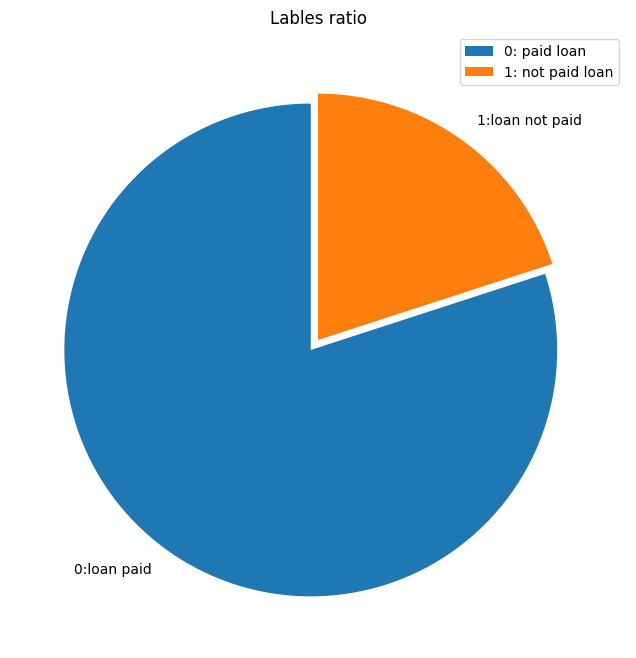

In [19]:
# pie chart
# data.bad_loan.value_counts().plot(kindz='pie', subplots=True, autopct='%1.2f%%', explode= (0.025, 0.05), startangle=80, legend=True, fontsize=14, figsize=(16,8), textprops={'color':"black"})
plt.figure(figsize = (8, 8))
ratio = data.bad_loan.value_counts().values
my_labels = ["0:loan paid", "1:loan not paid"]
explode = [0.05, 0.0]
plt.pie(ratio, labels = my_labels, explode = explode, startangle=90)

plt.legend(["0: paid loan","1: not paid loan"])
plt.title("Lables ratio")
plt.show();

**From the above plot we can see that our data is pretty much imbalanced.**

In [20]:
# Check for the Deatils reagarding the Missing value columns.

missing_details(data)

,name,missing_count,missing(%),data_type,no.of_unique,first_value,last_value
0,home_ownership,1491,7.455,object,3,RENT,MORTGAGE
0,dti,154,0.770,float64,3295,26.27,2.2
0,last_major_derog_none,19426,97.130,float64,2,NaN,NaN


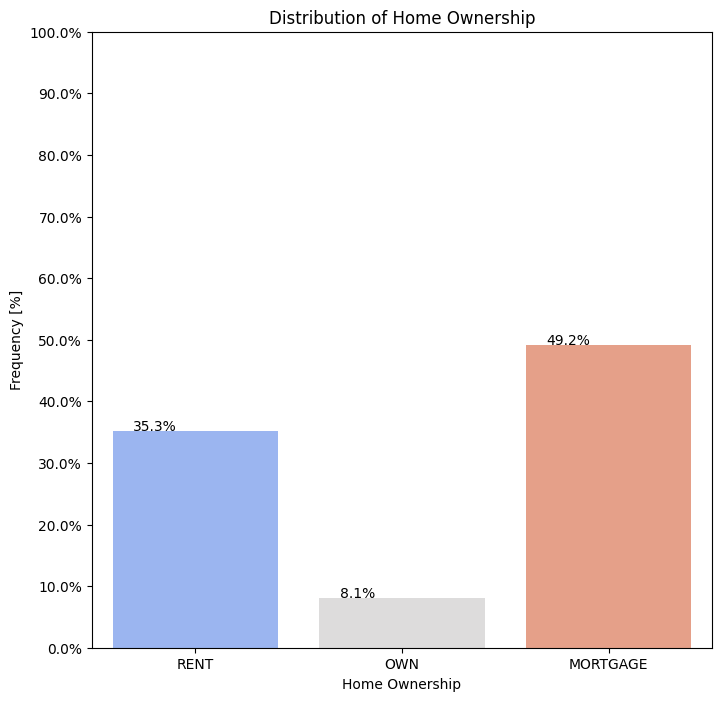

In [21]:
# Let's try to fill the missing values according to the feature significance.

# home_ownership
plt.figure(figsize=(8,8))
total = len(data) * 1
ax = sns.countplot(x = data["home_ownership"], palette = "coolwarm")
plt.title("Distribution of Home Ownership")
plt.xlabel("Home Ownership")
plt.ylabel('Frequency [%]')

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

<Figure size 1800x1000 with 0 Axes>

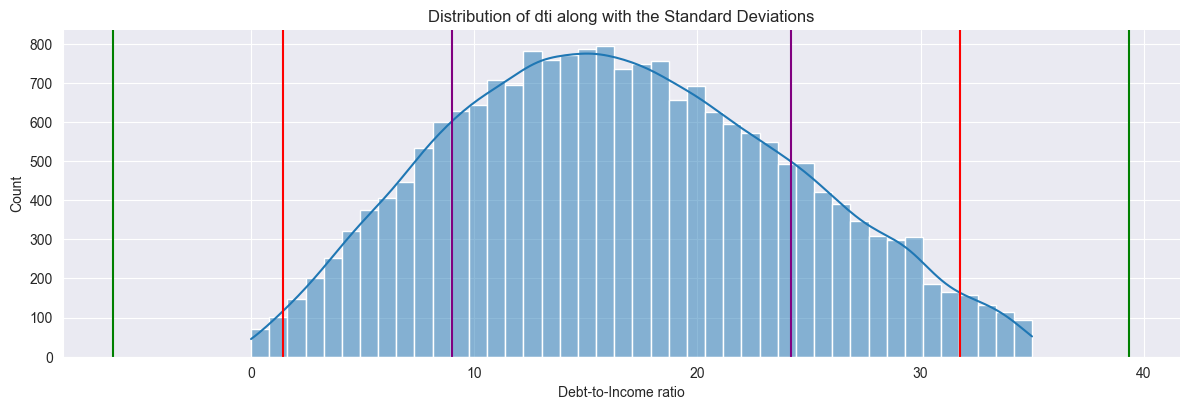

In [22]:
# Let's fill up the dti column.
# As we can see it is an Numerical columns. Let's try to find the distribution using histograms.

plt.figure(figsize=(18,10))
sns.set_style("darkgrid")
sns.displot(data["dti"], kde = True, height = 4, aspect = 3 )
plt.axvline(data["dti"].mean() + (1*data["dti"].std()), color = "purple")
plt.axvline(data["dti"].mean() - (1*data["dti"].std()), color = "purple")
plt.axvline(data["dti"].mean() + (2*data["dti"].std()), color = "red")
plt.axvline(data["dti"].mean() - (2*data["dti"].std()), color = "red")
plt.axvline(data["dti"].mean() + (3*data["dti"].std()), color = "green")
plt.axvline(data["dti"].mean() - (3*data["dti"].std()), color = "green")
plt.title("Distribution of dti along with the Standard Deviations")

plt.xlabel("Debt-to-Income ratio")
plt.show();

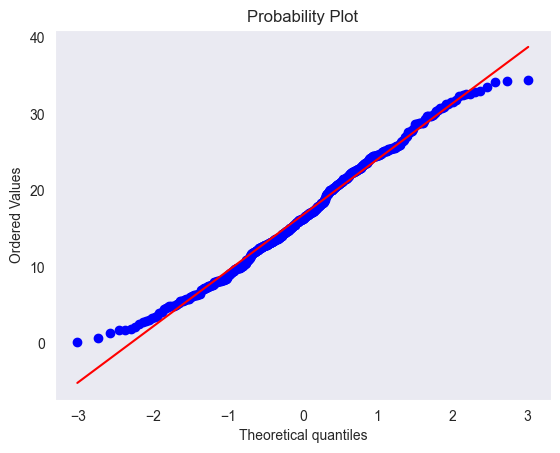

In [23]:
# Checking the Normality of the column.

stats.probplot(data.dropna()["dti"], dist = "norm",plot = plt)
plt.grid()

In [24]:
data.isnull().sum()

id                           0
event_timestamp              0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64

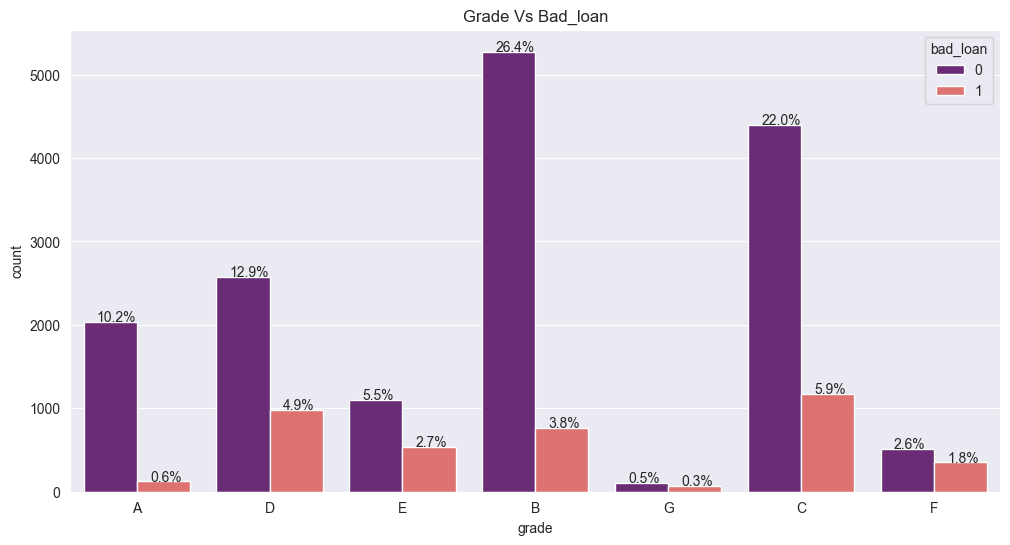

In [25]:
# Grade vs bad_loan.

plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
ax = sns.countplot(x = data["grade"], hue = data["bad_loan"], palette = "magma")
plt.title("Grade Vs Bad_loan")

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

- As we can see, Most of the Loans are getting accepted with the Grades B, C, D.

In [26]:
# Separating two dataframes for Default records and Non-Default records.

default_df = data[data["bad_loan"] == 1]
not_default_df = data[data["bad_loan"] == 0]

<Figure size 1800x1000 with 0 Axes>

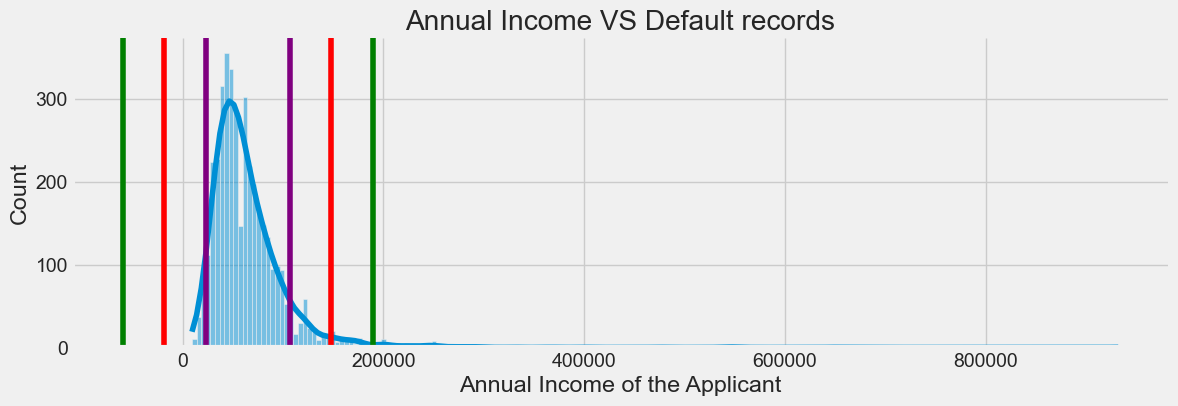

In [27]:
# Annual Income vs default records.
# Let's fill up the dti column.
# As we can see it is an Numerical columns. Let's try to find the distribution using histograms.
plt.figure(figsize=(18, 10))
plt.style.use("fivethirtyeight")
sns.displot(default_df["annual_inc"], kde = True, height = 4, aspect = 3 )
plt.axvline(default_df["annual_inc"].mean() + (1*default_df["annual_inc"].std()), color = "purple")
plt.axvline(default_df["annual_inc"].mean() - (1*default_df["annual_inc"].std()), color = "purple")
plt.axvline(default_df["annual_inc"].mean() + (2*default_df["annual_inc"].std()), color = "red")
plt.axvline(default_df["annual_inc"].mean() - (2*default_df["annual_inc"].std()), color = "red")
plt.axvline(default_df["annual_inc"].mean() + (3*default_df["annual_inc"].std()), color = "green")
plt.axvline(default_df["annual_inc"].mean() - (3*default_df["annual_inc"].std()), color = "green")
plt.title("Distribution of Annual Income of the persons who are not returning the Loans")

plt.xlabel("Annual Income of the Applicant")
plt.title("Annual Income VS Default records")
plt.show();

**Most of the People, who are not returning their loan amount are having their Annual income between 0 to 200000.**

<Figure size 1800x1000 with 0 Axes>

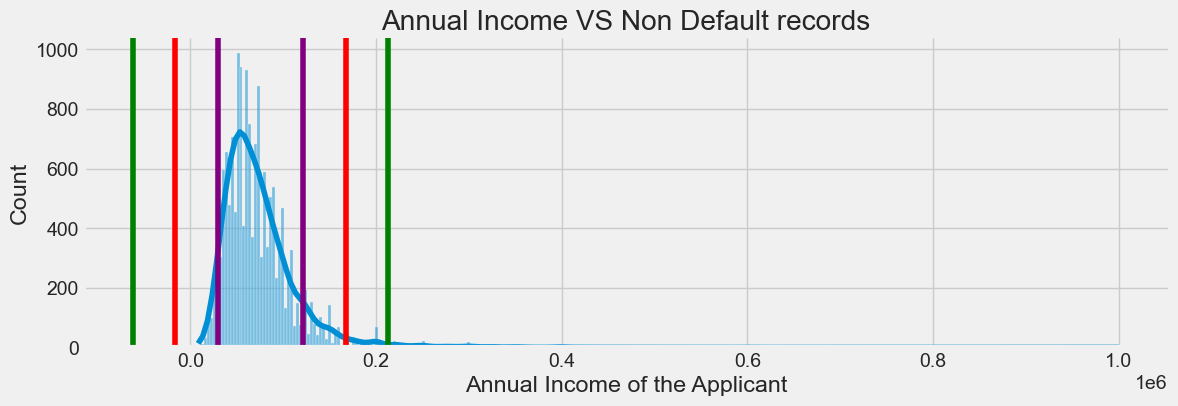

In [28]:
# Annual Income vs not_default records.
# Let's fill up the dti column.
# As we can see it is an Numerical columns. Let's try to find the distribution using histograms.

plt.figure(figsize=(18, 10))
plt.style.use("fivethirtyeight")
sns.displot(not_default_df["annual_inc"], kde = True, height = 4, aspect = 3 )
plt.axvline(not_default_df["annual_inc"].mean() + (1*not_default_df["annual_inc"].std()), color = "purple")
plt.axvline(not_default_df["annual_inc"].mean() - (1*not_default_df["annual_inc"].std()), color = "purple")
plt.axvline(not_default_df["annual_inc"].mean() + (2*not_default_df["annual_inc"].std()), color = "red")
plt.axvline(not_default_df["annual_inc"].mean() - (2*not_default_df["annual_inc"].std()), color = "red")
plt.axvline(not_default_df["annual_inc"].mean() + (3*not_default_df["annual_inc"].std()), color = "green")
plt.axvline(not_default_df["annual_inc"].mean() - (3*not_default_df["annual_inc"].std()), color = "green")
plt.title("Distribution of Annual Income of the persons who are properlly returned their Loans")
plt.xlabel("Annual Income of the Applicant")
plt.title("Annual Income VS Non Default records")
plt.show();

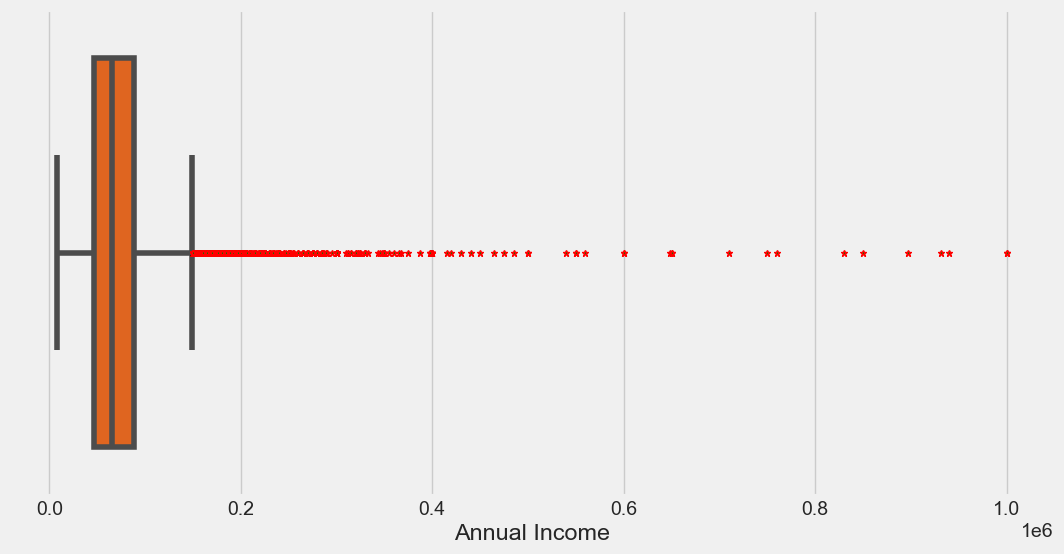

In [29]:
# Finding the Outliers .

marker = dict(markerfacecolor='green', markeredgecolor='red', markersize=5, marker='*')
plt.figure(figsize = (12, 6))
sns.boxplot(x = data["annual_inc"], palette = "hot", flierprops = marker)
plt.xlabel("Annual Income");

**Here most of the persons who are returning their loans are earning between 0 to 200000.**

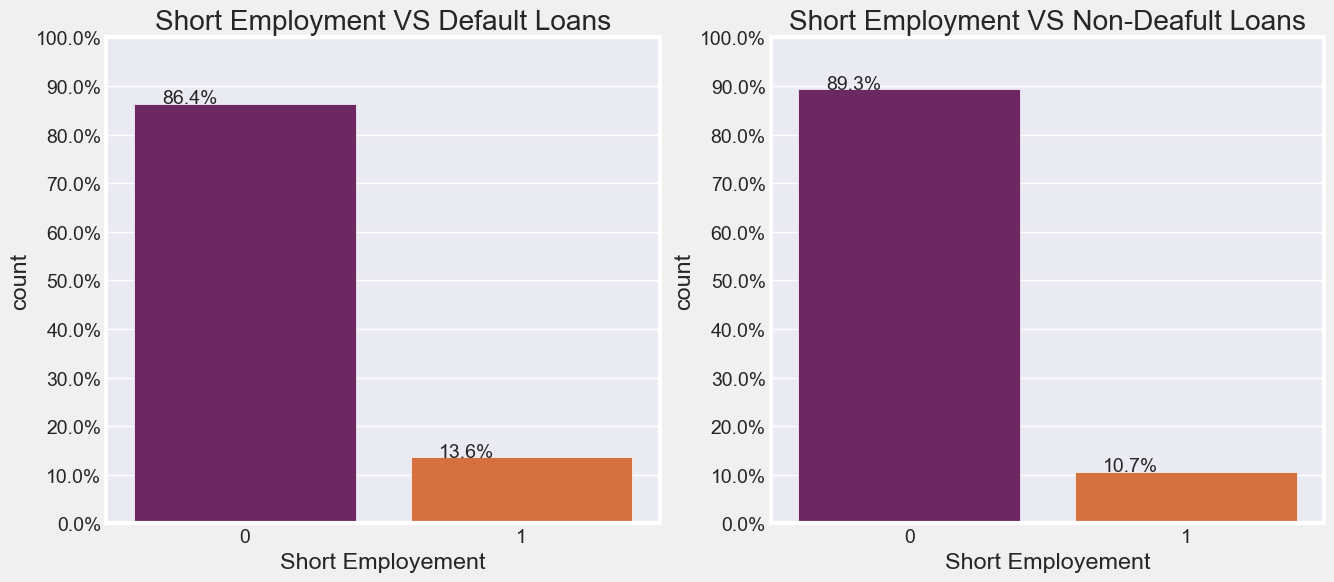

In [30]:
# Short Employment Duration.

plt.figure(figsize = (14, 6))
sns.set_style("darkgrid")
total = len(default_df)
plt.subplot(1, 2, 1)
ax = sns.countplot(x = default_df["short_emp"], palette = "inferno")
plt.xlabel("Short Employement")
plt.title("Short Employment VS Default Loans")

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

plt.subplot(1, 2, 2)
ax = sns.countplot(x = not_default_df["short_emp"],  palette = "inferno")
total = len(not_default_df)
plt.xlabel("Short Employement")
plt.title("Short Employment VS Non-Deafult Loans")

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

- We can see that there is 3% higher chances that Short employement people may not return their Loans.

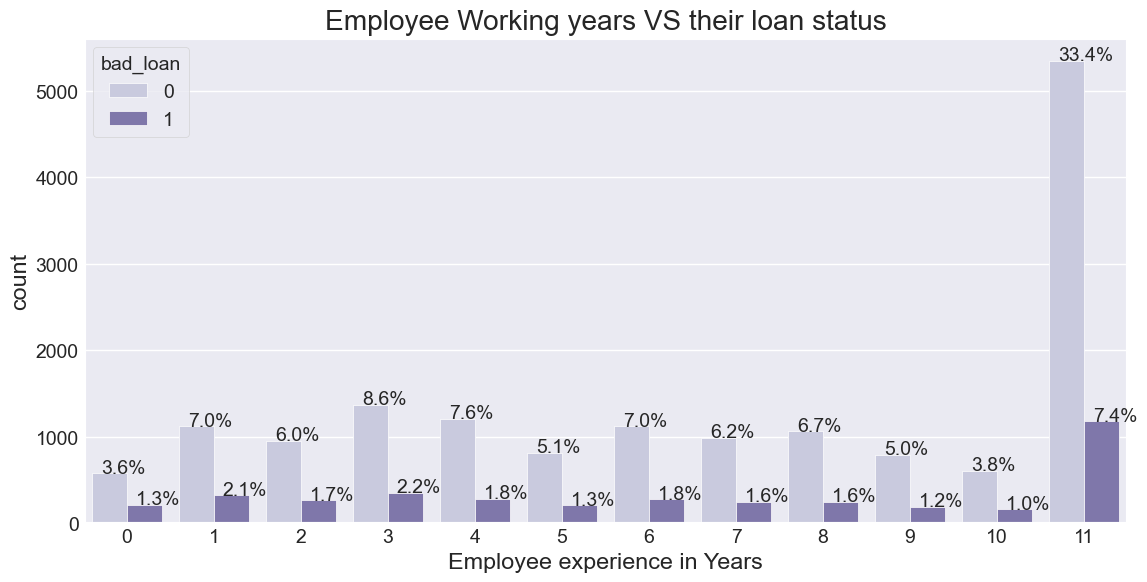

In [31]:
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
ax = sns.countplot(x = data["emp_length_num"],hue = data["bad_loan"], palette = "Purples")
plt.xlabel("Employee experience in Years")
plt.title("Employee Working years VS their loan status")

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

From the Above plot we can notice that Most of the people who are taking their Loans having Employement Experience of more than 10 Years.

In [32]:
# Home Ownership

data["home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', nan], dtype=object)

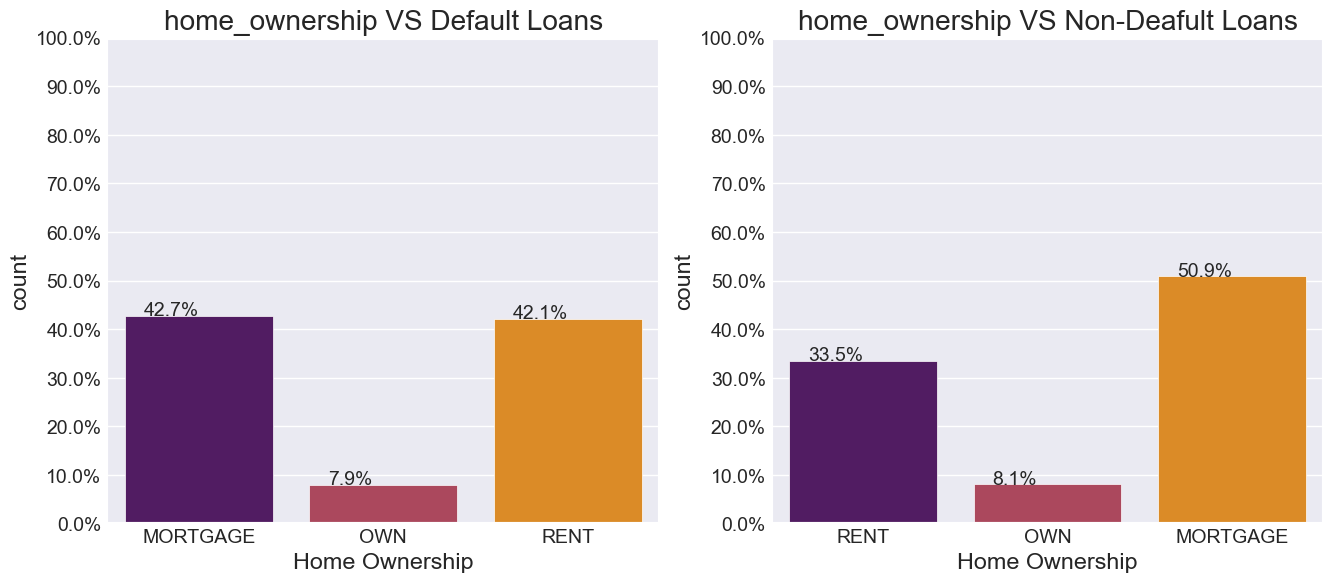

In [33]:
# Short Employment Duration.

plt.figure(figsize = (14, 6))
sns.set_style("darkgrid")
total = len(default_df)
plt.subplot(1, 2, 1)
ax = sns.countplot(x = default_df["home_ownership"], palette = "inferno")
plt.xlabel("Home Ownership")
plt.title("home_ownership VS Default Loans")

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

plt.subplot(1, 2, 2)
ax = sns.countplot(x = not_default_df["home_ownership"],  palette = "inferno")
total = len(not_default_df)
plt.xlabel("Home Ownership")
plt.title("home_ownership VS Non-Deafult Loans")

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

Most of the People who are taking loans either having a mortgage or staying in a rented house. Own home owner ship people are taking less loans in comparision.

<Figure size 800x600 with 0 Axes>

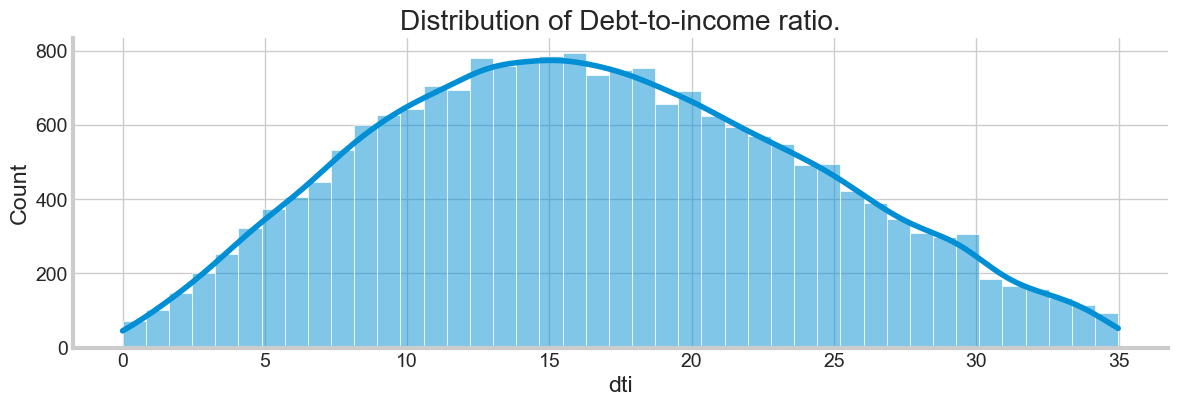

In [34]:
# dti (Debt-to-income ratio)

plt.figure(figsize = (8,6))
sns.set_style("whitegrid")
sns.displot(data["dti"], kde = True, height = 4, aspect = 3)
plt.title("Distribution of Debt-to-income ratio.");

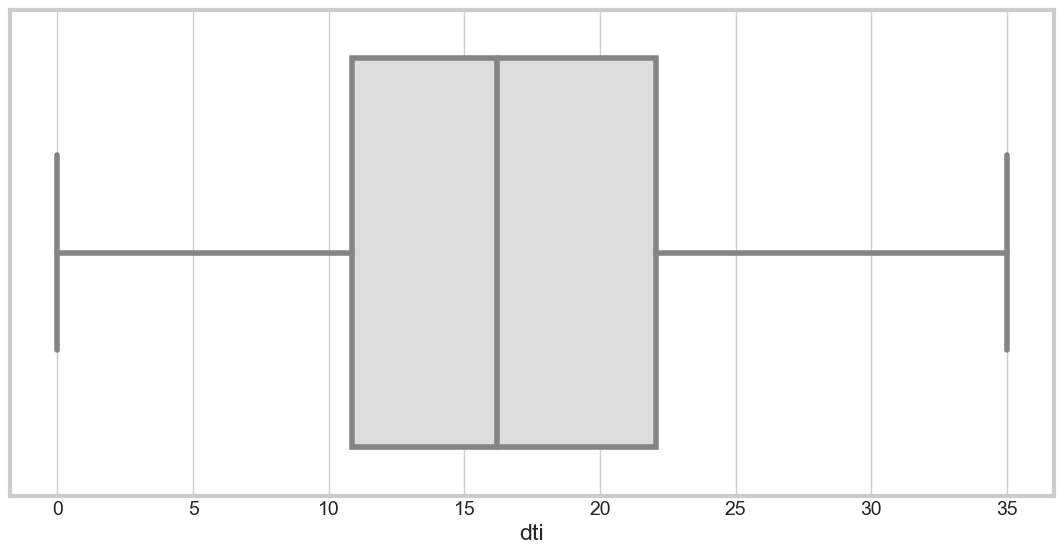

In [35]:
# Trying to find the Outliers.

plt.figure(figsize = (12,6))
sns.boxplot(x = data["dti"],palette = "coolwarm", flierprops = marker);

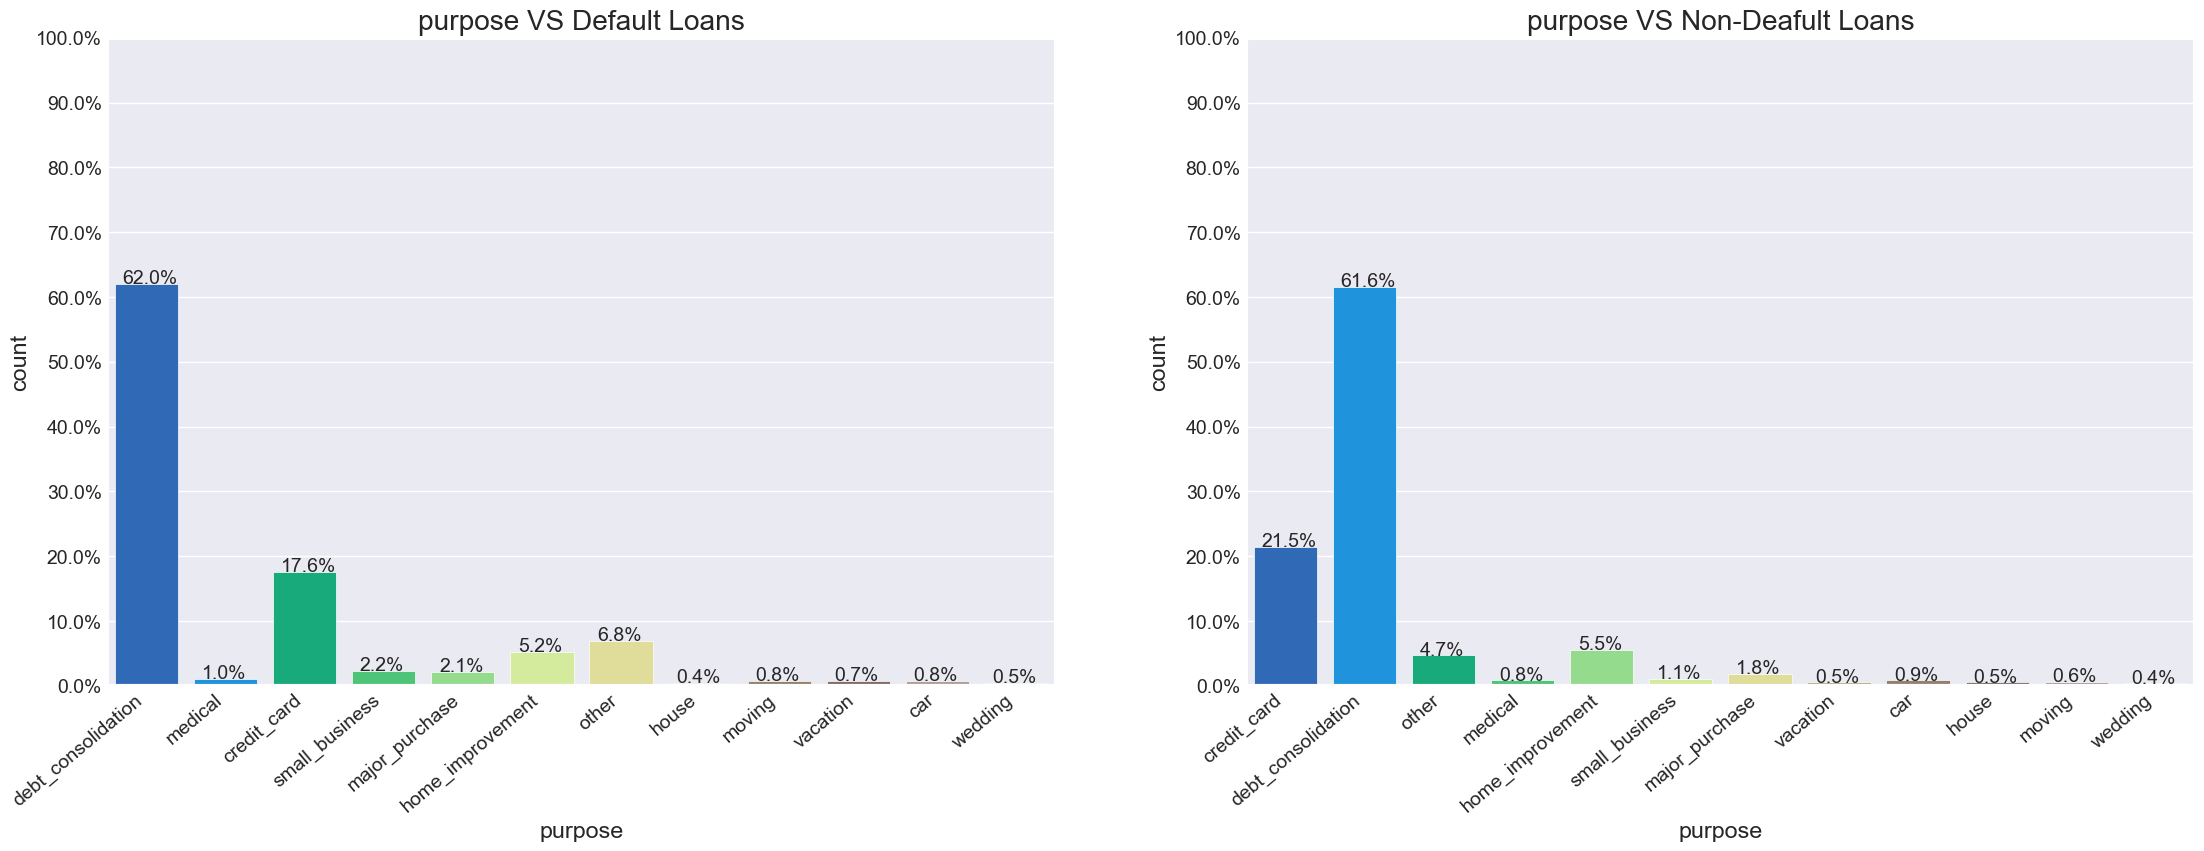

In [36]:
# Purpose of taking the Loan from Lending bank.
# Short Employment Duration.

plt.figure(figsize = (24, 8))
sns.set_style("darkgrid")
total = len(default_df)
plt.subplot(1, 2, 1)
ax = sns.countplot(x = default_df["purpose"], palette = "terrain")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("purpose VS Default Loans")

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

plt.subplot(1, 2, 2)
total = len(not_default_df)
ax = sns.countplot(x = not_default_df["purpose"],  palette = "terrain")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("purpose VS Non-Deafult Loans")

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

Most of the Default loans are happening from debt consolidataion and credit card reasons.

In [37]:
# Terms ,The number of installments to repay the loan amount.

data["term"].value_counts()

term
 36 months    14969
 60 months     4999
 36 Months       32
Name: count, dtype: int64

There is two type of terms 60 months and 36 months, most of the loans are taking for 36 months term.

In [38]:
# There is a typical mistake in 36 Months,Because of that we are getting 3 terms,When there is only two. let's fix that.

data["term"] = data["term"].apply(lambda x: x.replace("Months", "months"))

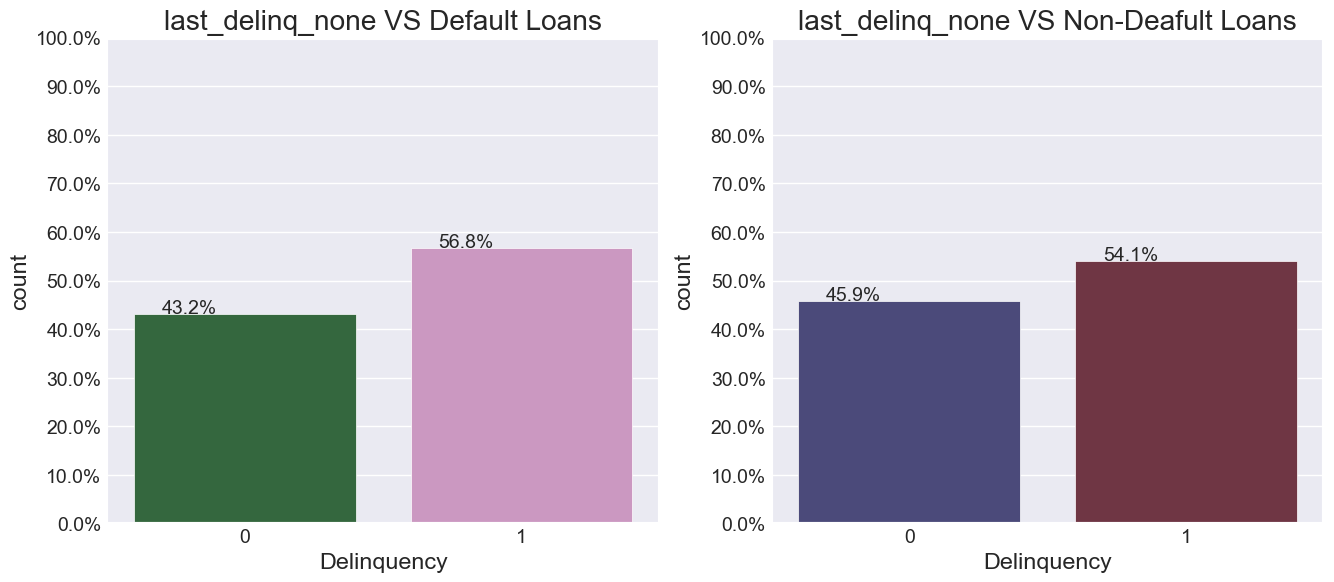

In [39]:
# last_delinq_none
# If the customer had any past history with delinquency or not.
# Short Employment Duration.

plt.figure(figsize = (14, 6))
sns.set_style("darkgrid")
total = len(default_df)
plt.subplot(1, 2, 1)
ax = sns.countplot(x = default_df["last_delinq_none"], palette = "cubehelix")
plt.xlabel("Delinquency")
plt.title("last_delinq_none VS Default Loans")

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

plt.subplot(1, 2, 2)
ax = sns.countplot(x = not_default_df["last_delinq_none"],  palette = "icefire")
total = len(not_default_df)
plt.xlabel("Delinquency")
plt.title("last_delinq_none VS Non-Deafult Loans")

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

If we compare both the plot for Default & non deafult loans with deliquency, there is approximately 6% chance that a person who is having deliquency in past may found out in not paying the loan amount.

<Figure size 1400x600 with 0 Axes>

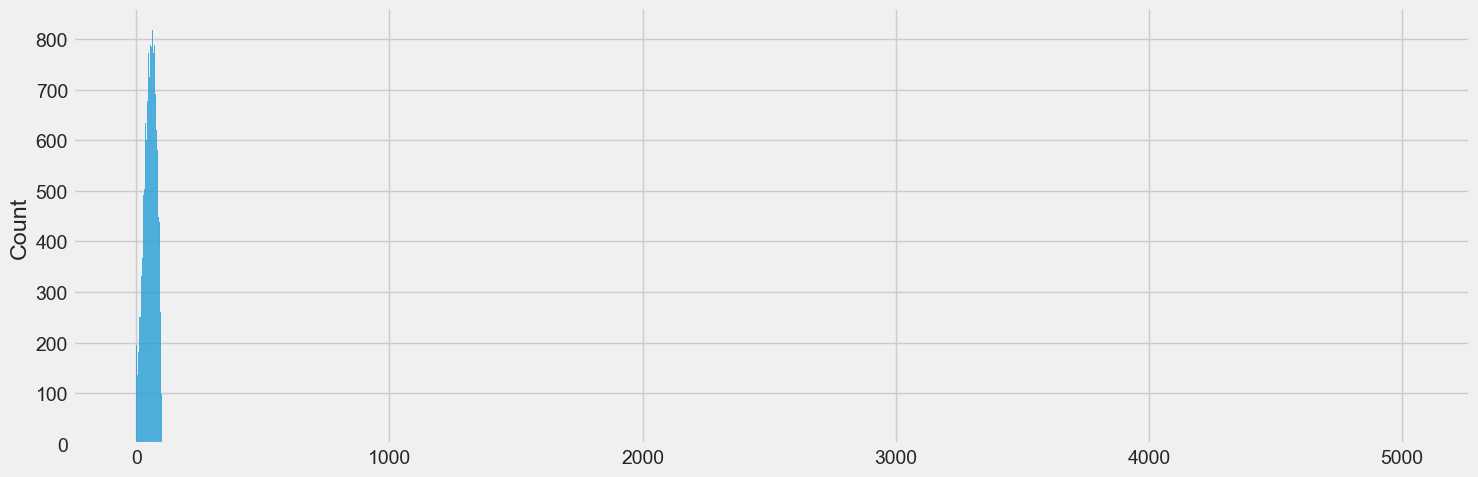

In [40]:
# revol_util 
# Revolving line utilization rate, it's how much you currently owe divided by your credit limit. It is generally expressed as a percent.

plt.style.use("fivethirtyeight")
plt.figure(figsize = (14,6))
sns.displot(x = data["revol_util"].values, height = 5, aspect = 3);

The Above plot looking a bit weird, let's find out is there any outliers in the feature.

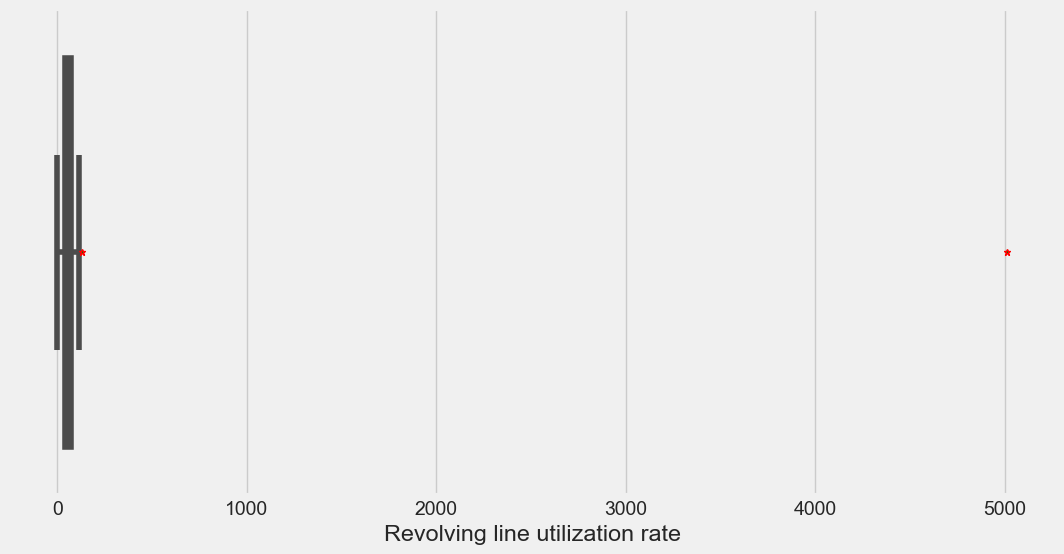

In [41]:
# Plotting a box plot to notice Outliers.

plt.figure(figsize = (12,6))
sns.boxplot(x = data["revol_util"],palette = "hot", flierprops = marker)
plt.xlabel("Revolving line utilization rate");

In [42]:
# Got it, As we can see from the above there is an Outlier at the Extreme end of the Plot. Let's find out that and replace it with the mean or median.

data["revol_util"].sort_values()

11739       0.0
4289        0.0
6988        0.0
14323       0.0
8924        0.0
          ...  
11712     107.7
19809     109.1
7880      112.9
2643      128.1
100      5010.0
Name: revol_util, Length: 20000, dtype: float64

In [43]:
# As we can see that 5010 is completely abnormal from the remaining values, all the values are in between 0 to 128.
# Let's replace it with Median.

data.loc[data["revol_util"] == max(data["revol_util"]), "revol_util"] = data["revol_util"].median()
data.loc[data["revol_util"] == max(data["revol_util"]), "revol_util"] = data["revol_util"].median()

<Figure size 1400x600 with 0 Axes>

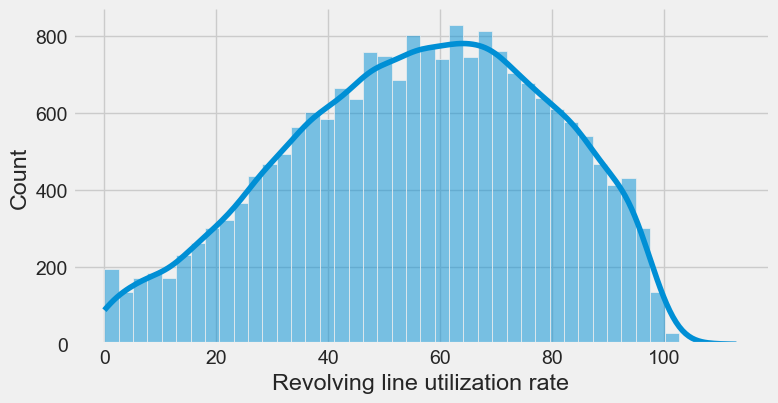

In [44]:
# As we can see that, the data is pretty normal.

plt.style.use("fivethirtyeight")
plt.figure(figsize = (14,6))
sns.displot(x = data["revol_util"].values, kde = True, height = 4, aspect = 2)
plt.xlabel("Revolving line utilization rate");

In [45]:
# od_ratio, Over Draft Ratio 

data["od_ratio"].sort_values()

3927     0.000077
16538    0.000110
12800    0.000217
16059    0.000300
963      0.000598
           ...   
2377     0.999791
1038     0.999798
6825     0.999877
5784     0.999890
2810     0.999894
Name: od_ratio, Length: 20000, dtype: float64

The Over Draft ratio distributed in between 0 to 1, in percnetile.

<Figure size 1000x600 with 0 Axes>

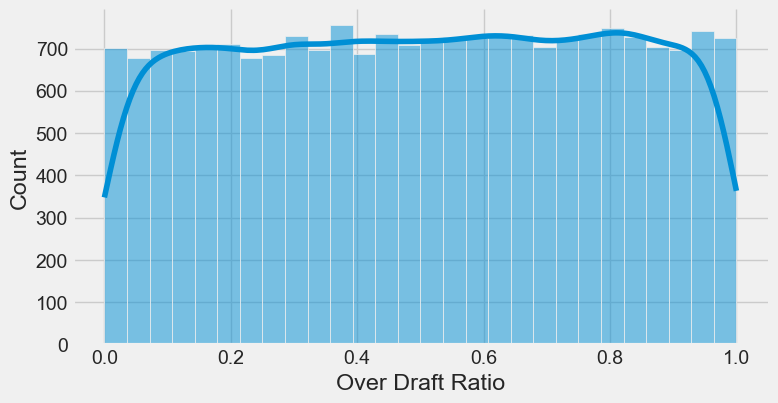

In [46]:
# As we can see that, the data is pretty normal.

plt.style.use("fivethirtyeight")
plt.figure(figsize = (10,6))
sns.displot(x = data["od_ratio"].values, kde = True, height = 4, aspect = 2)
plt.xlabel("Over Draft Ratio");

### Feature Engineering 

In [47]:
# As we can see half of the values are from "MORTAGE". So, we can fill it with the mode .

data["home_ownership"] = data["home_ownership"].fillna(data["home_ownership"][0])

# It was looking like an Normally distributed feature, So we can fill it with either mean or median.
# here i'm filling with the Median of the Column.

data["dti"] = data["dti"].fillna(data["dti"].median())

# As we can see there is no significancal impact on target with the feature "last_major_derog_none", so let's remove the column.

data.drop("last_major_derog_none", axis = 1, inplace=True)

In [48]:
# separating the numerical features and object features.

obj_cols = [col for col in data.columns if col in data.select_dtypes(include = "O")]

In [49]:
# We don't want event timestamp in the obj cols, let's remove it.

# obj_cols.remove("event_timestamp")

In [50]:
# Filtering out the Numerical columns

num_cols = [col for col in data.columns if col not in obj_cols]

In [51]:
# Finding the Number of Unique lables in Object Columns.

data[obj_cols].nunique()

event_timestamp    16402
grade                  7
home_ownership         3
purpose               12
term                   2
dtype: int64

**One-Hot Encoding for Object columns.**

In [52]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(data[obj_cols]).toarray(),columns = enc.get_feature_names_out(obj_cols))
with open('One_Hot_Encoder.pkl', 'wb') as files:
    pickle.dump(enc, files)

# merge with main df bridge_df on key values

enc_df = data.join(enc_df)

In [53]:
clean_data = enc_df.drop(obj_cols, axis = 1)

In [54]:
# Before doing the training. We need to split the data for training and testing.
# Separating the data into Dependent and independent features.

X = clean_data.drop(["id","bad_loan"],axis = 1)
y = clean_data["bad_loan"]

#### Splitting the Data in 80:20 ratio for train and test repectively.

In [56]:
# Splitting the Dataset.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

MemoryError: Unable to allocate 1.96 GiB for an array with shape (16426, 16000) and data type float64

In [ ]:
# Creating a new experiment using set_exp function from ml client.

mlflow.set_experiment(experiment_name="default-loan-prediction")

In [ ]:
# Modelling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from mlflow import log_metric, log_param, log_params, log_artifacts

In [ ]:
def eval_metrics(actual, pred):
        
    accuracy_score_val = accuracy_score(actual,pred)
    recall_score_val = recall_score(actual, pred)
    precision_score_val = precision_score(actual, pred)
    f1_score_val = f1_score(actual,pred)
    roc_auc_score_val = roc_auc_score(actual,pred)
    
    return accuracy_score_val,recall_score_val, precision_score_val, f1_score_val,roc_auc_score_val

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    # "Lasso": Lasso(),
    # "Ridge": Ridge(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [ ]:
model_list = []
auc_roc_list =[]

In [ ]:
with mlflow.start_run():

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate Train and Test dataset

        (accuracy_train_val,recall_train_val, precision_train_val, f1_train_val,roc_auc__train_val) = eval_metrics(y_train, y_train_pred)
        (accuracy_test_val,recall_test_val, precision_test_val, f1_test_val,roc_auc__test_val) = eval_metrics(y_test, y_test_pred)

        print(list(models.keys())[i])
        model_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy Score: {:.4f}".format(accuracy_train_val))
        print("- Recall Score: {:.4f}".format(recall_train_val))
        print("- Precision Score: {:.4f}".format(precision_train_val))
        print("- f1 Score: {:.4f}".format(f1_train_val))
        print("- roc_auc Score: {:.4f}".format(roc_auc__train_val))
    

        print('----------------------------------')
        
        print('Model performance for Test set')
        print("- Accuracy Score: {:.4f}".format(accuracy_train_val))
        print("- Recall Score: {:.4f}".format(recall_train_val))
        print("- Precision Score: {:.4f}".format(precision_train_val))
        print("- f1 Score: {:.4f}".format(f1_train_val))
        print("- roc_auc Score: {:.4f}".format(roc_auc__train_val))

        auc_roc_list.append(roc_auc__train_val)
        
        print('='*35)
        print('\n')

        mlflow.log_metric("accuracy_val", accuracy_test_val)
        mlflow.log_metric("recall_val", recall_test_val)
        mlflow.log_metric("precision_val", precision_test_val)
        mlflow.log_metric("f1_val", f1_test_val)
        mlflow.log_metric("roc_auc__val", roc_auc__test_val)

        mlflow.sklearn.log_model(model, "model")

    

In [ ]:
pd.DataFrame(list(zip(model_list, auc_roc_list)), columns=['Model Name', 'roc_auc_Score']).sort_values(by=["roc_auc_Score"],ascending=False)